In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
%cd
%cd public/data/Lab1

/home/acardaras
/home/acardaras/public/data/Lab1


Define all functions used

In [218]:
def sum_list(x):                       #Define a function to find the sum
    summation = 0                           
    for i in range(len(x)):            #Loops through each element in the list x
        summation += x[i]              #Sums each element in the list x
    return(summation)

def mean_list(x):                      #Define function to find the mean
    return(sum_list(x)/len(x))         #Calculates the mean by using the sum funcation

def std_list(x):                       #Define function to find the std
    temp = 0                           #Define variable that is a part of the std
    mean = mean_list(x)                #Uses the mean_list function to find the mean
    for i in range(len(x)):            #Loop through each element in the input list
        temp = temp + (x[i]-mean)**2   #Sum the diffence between the element at index i and the mean, then square the difference
    std = (1/len(x))*temp              #Divide by the numebr of elements in the list
    return(std**.5)                    #Square root

def histogram(x,name):                      #Define histogram function that doesn't use plt.hist
    hmin = 50                               #Starts at 50 since that is where the over scan shows
    hmax = x.max()
    values=np.arange(hmin,hmax+1)           #Creates a list of elements from the minimum to max value
    freq = []
    for i in values:                        #Counts every time each time a value is repeated
        counts = len(np.where(x==i)[0])
        freq.append(counts)
    plt.plot(values, freq, label = 'd20%i.fits' %name)
    plt.xlabel('Counts(ADU)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig('d20%i.png' %name)
    plt.show()

def poisson(x,u):
    log_factorial = np.log((2*np.pi*x)**.5) + (x) * np.log(x) - x
    # log_factorial = np.log((2*np.pi)**.5) + (x + .5) * np.log(x) - x
    log_poisson = x * np.log(u) - log_factorial - u
    return(np.e ** log_poisson)
                           

Finds the median of the bias files

In [212]:
#cd into directory with files
%cd
%cd public/data/Lab1

data = glob.glob('*.fits')            #Imports data
data_sorted = sorted(data)            #Sorts the data starting from d2000.fits 
arr = fits.getdata('d2000.fits')      #Imports a file which is used to get the length of the flattened fits file, which will be used to preallocate an array
flat = arr.flatten()

raw_array = np.zeros((11,len(flat)))   #Creates a array that will hold the median value of each fits file, each row represents a file and each column represents a pixel
median_bias = []

n = 0
for i in data_sorted[:11]:                #Iterates through the name of every bias file (first 11 files)
    arr = fits.getdata(i)                 #Imports a bias file
    flat = arr.flatten()                  #Flattens the bias file
    raw_array[n] = flat                   #Fills the array where each fits file is represented as a row
    n += 1
for j in range(len(flat)):                                      #Iterates through the number of pixels
    median_bias.append(np.median(raw_array[:,j]))               #Takes the median of each column (each element along a column is the same pixel but from different fits files)
median_nparray = np.array(median_bias).reshape([1024,1056])     #Turns median file into the same shape as the image before it was flattened

/home/acardaras
/home/acardaras/public/data/Lab1


In [213]:
#cd into directory with files
%cd
%cd private/ASTR_150/Lab_1

bias_median_image = []                                                                 #Creates of list where each element is the name of every calibrated fits file that is ordered

filename = 'bias_median.fits'                              #Determines what to name each calibrated file
fits.writeto(filename,median_nparray,  overwrite = True)                   #Creates the fits file
print(f'Saved FITS file: {filename}')

/home/acardaras
/home/acardaras/private/ASTR_150/Lab_1
Saved FITS file: bias_median.fits


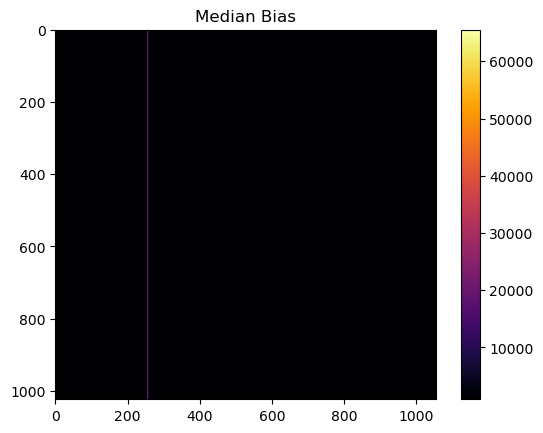

In [214]:
#Uses plt to plot a heatmap of the median bias

hdulist = fits.open('bias_median.fits')
image_data = hdulist[0].data
plt.imshow(image_data, cmap='inferno')
plt.colorbar()
plt.title('Median Bias')
plt.savefig('Median.png')
plt.show()

Remove the median of the bias from the data

In [215]:
#cd into directory with files
%cd
%cd public/data/Lab1

removed_bias = np.zeros((len(data)-11,len(flat)))   #Creates a array that will hold the value of a fits file subtracted by the median
flat_median = median_nparray.flatten()              #Flattens the median array

j = 0
for i in data_sorted[11:]:                              #Loops through every non-bias file
    arr = fits.getdata(i)                               #Uses astropy to read the fits file
    flat = arr.flatten()                                #Flattens the fits file into a list
    removed_bias[j,:] += (flat - flat_median)           #Removes the bias
    j += 1


/home/acardaras
/home/acardaras/public/data/Lab1


In [216]:
removed_bias[removed_bias<0] = 0                        #If a value is negative I set it to zero

Plot and save a histogram for each fits file with the median bias removed

/home/acardaras
/home/acardaras/private/ASTR_150/Lab_1/Images


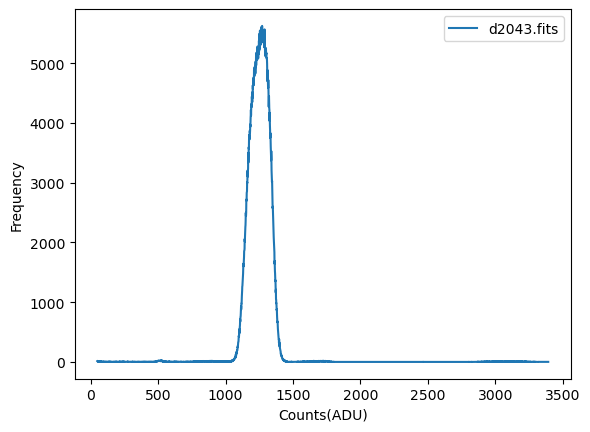

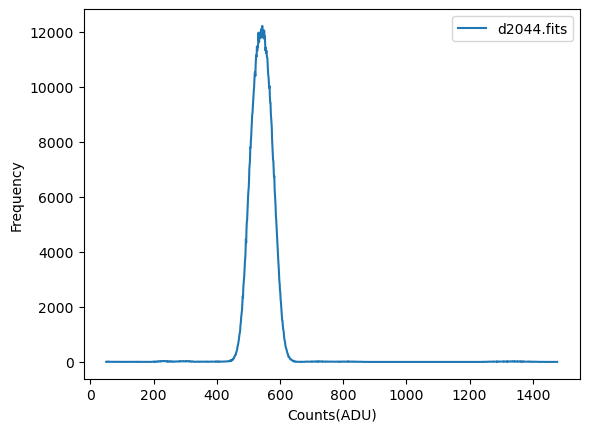

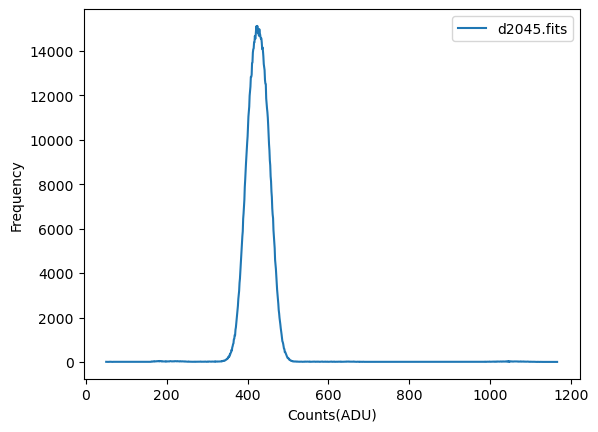

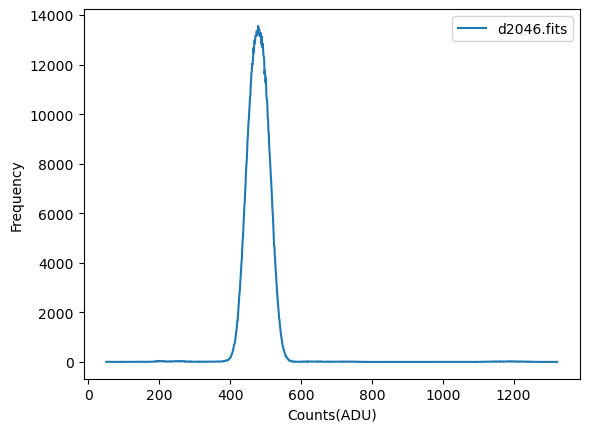

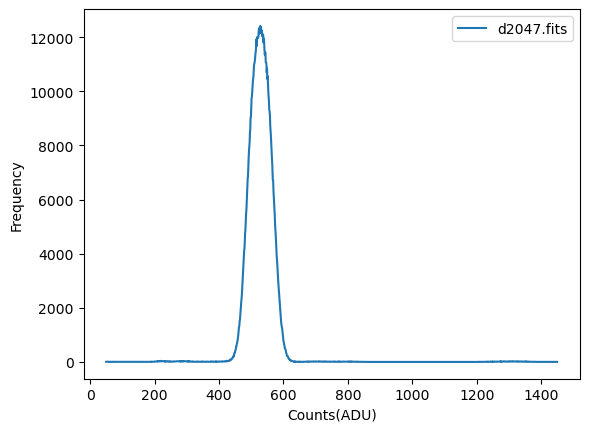

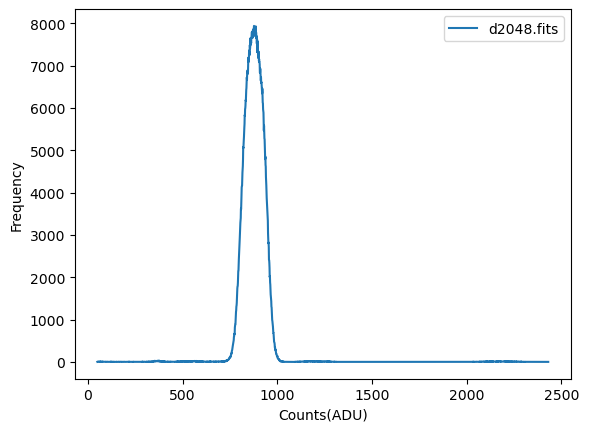

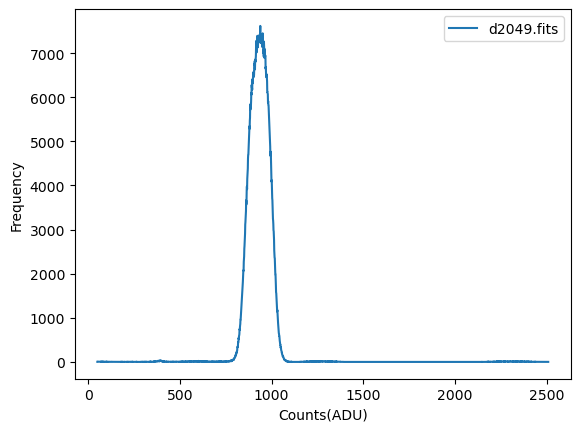

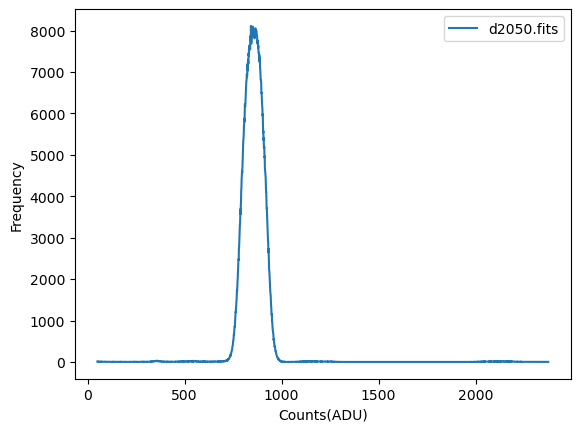

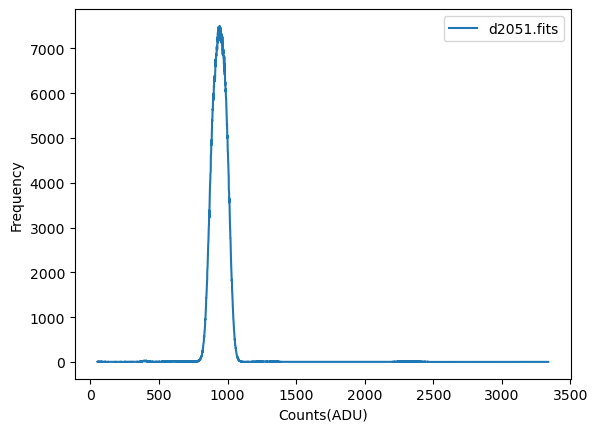

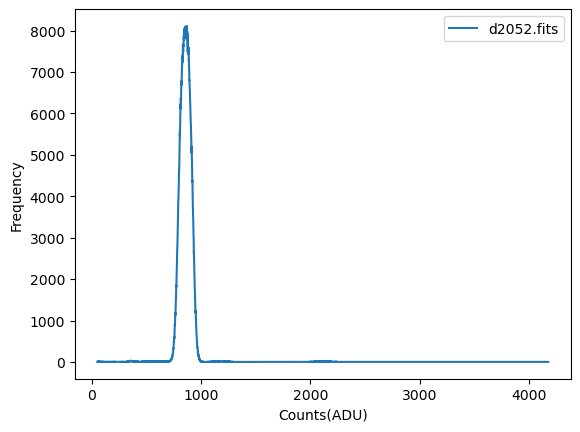

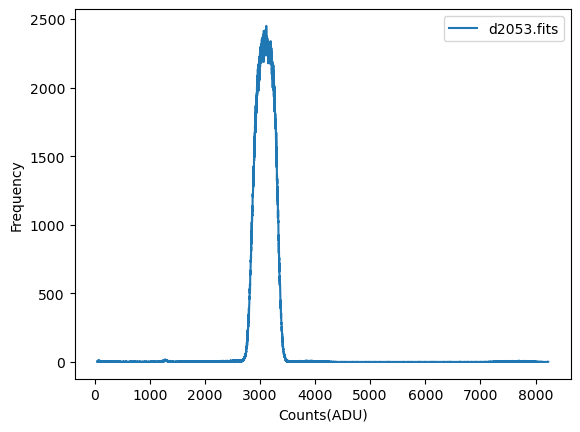

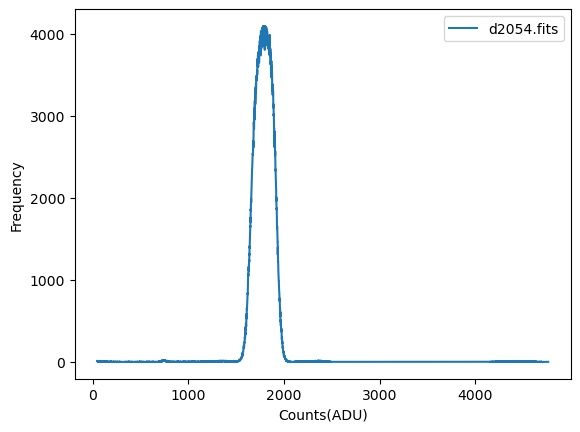

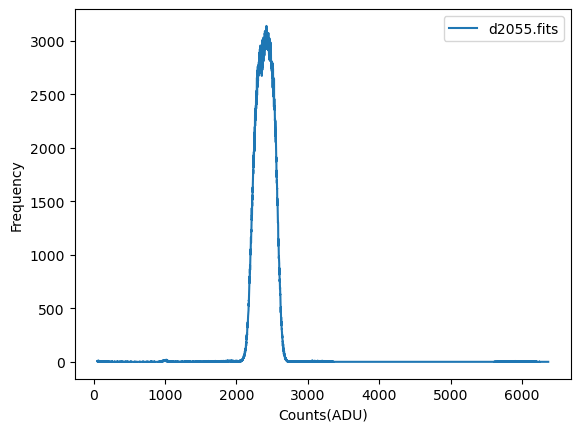

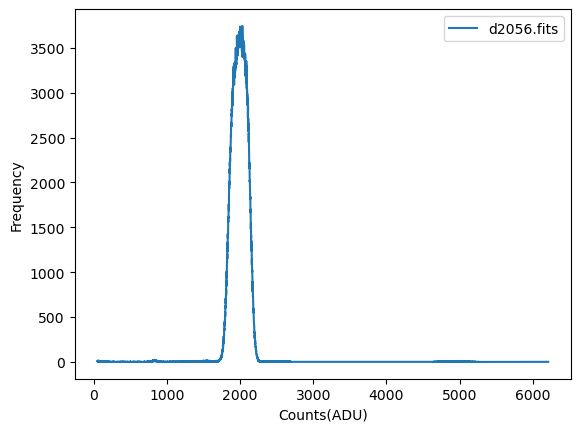

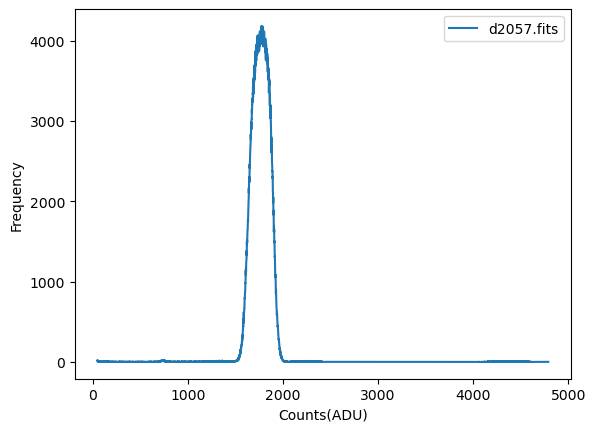

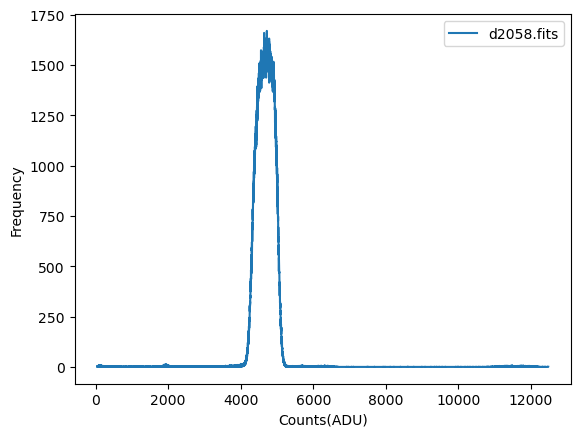

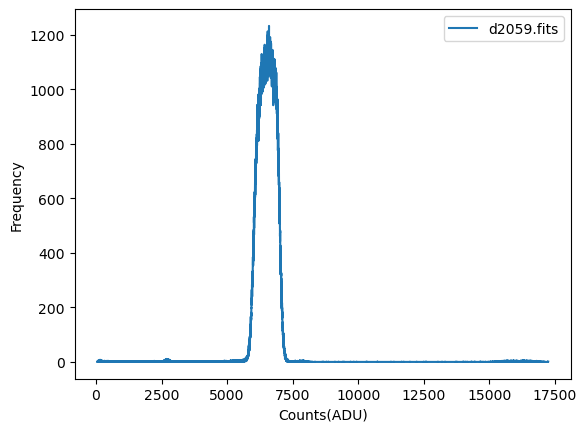

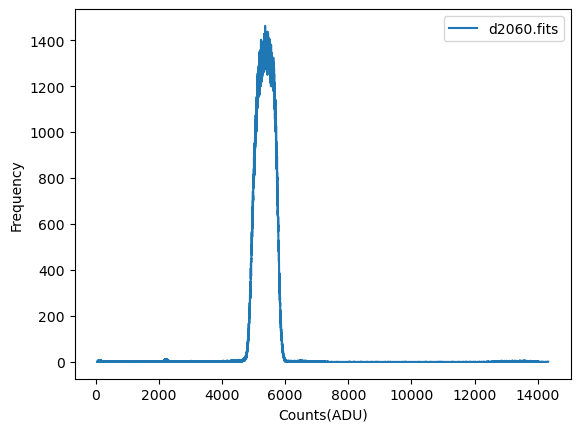

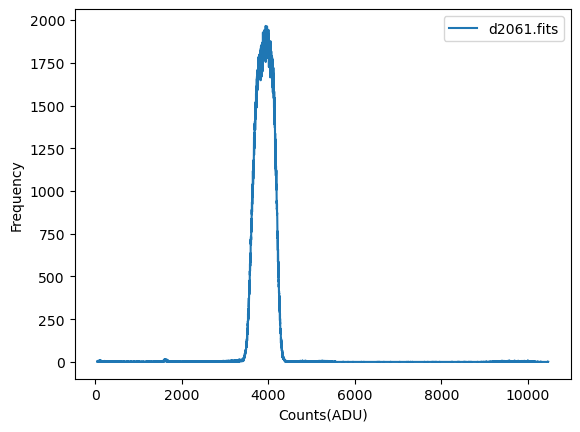

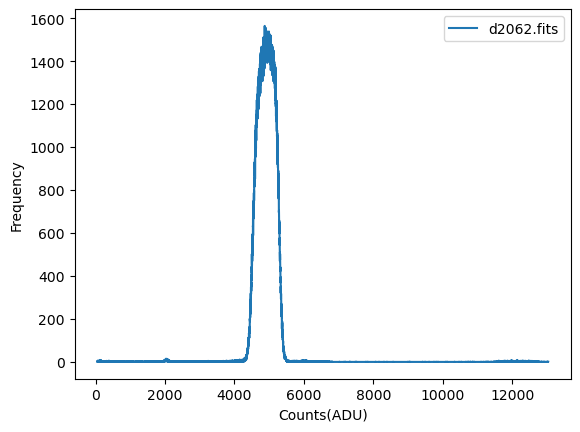

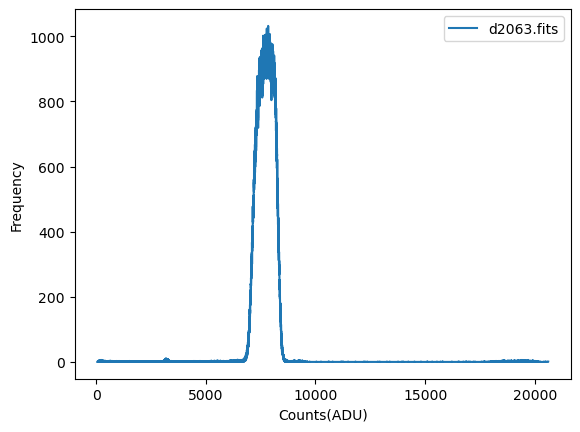

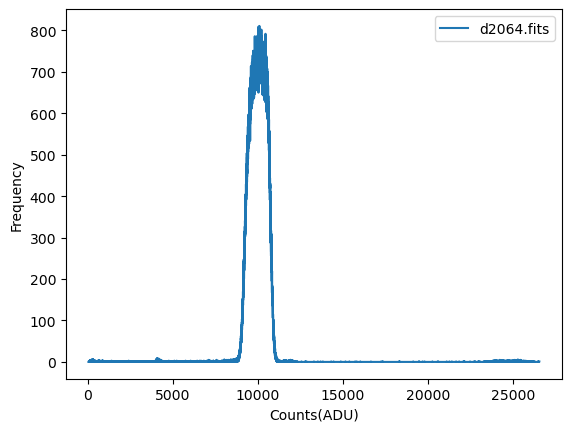

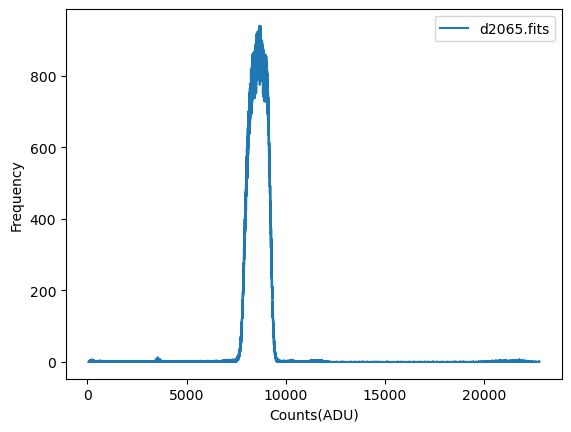

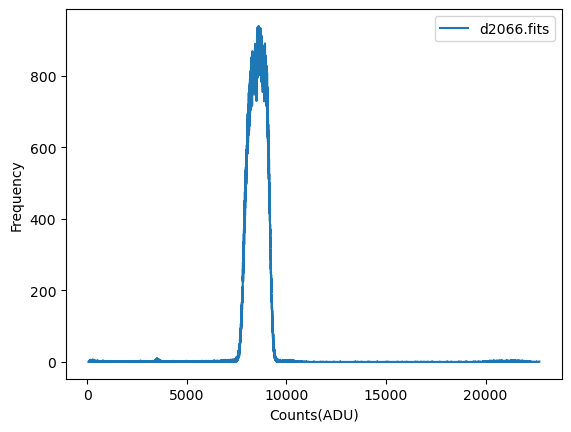

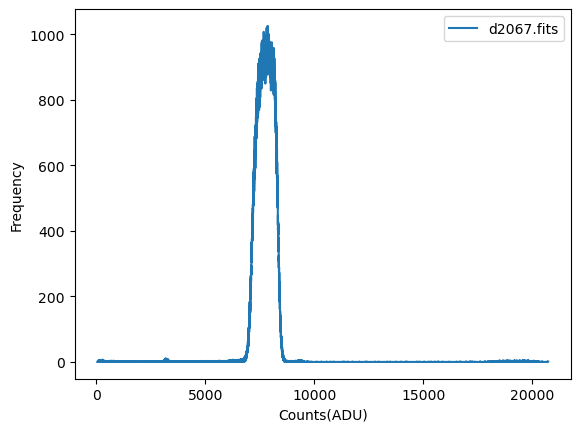

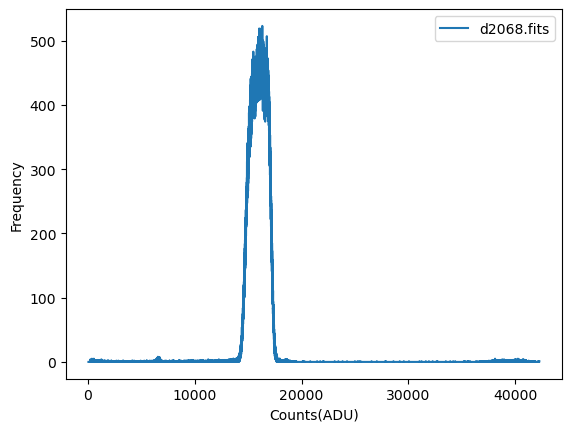

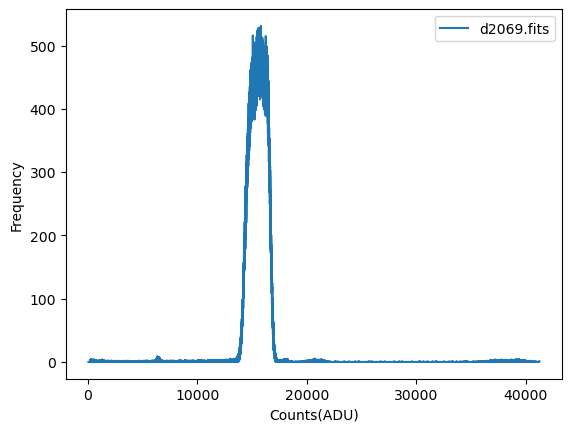

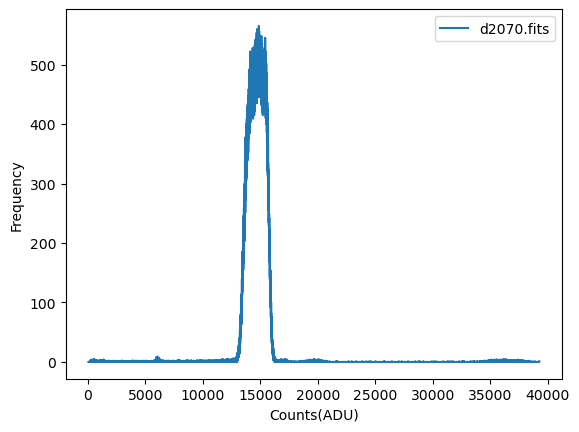

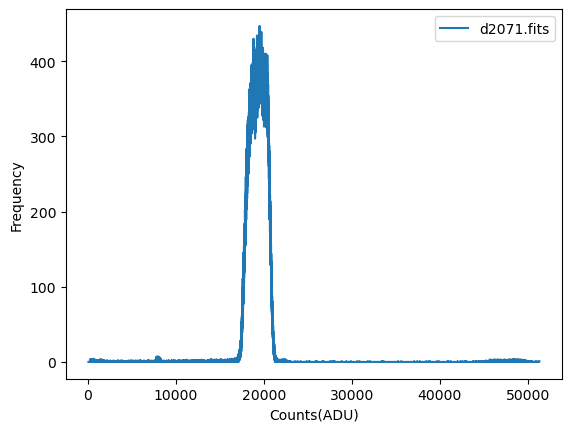

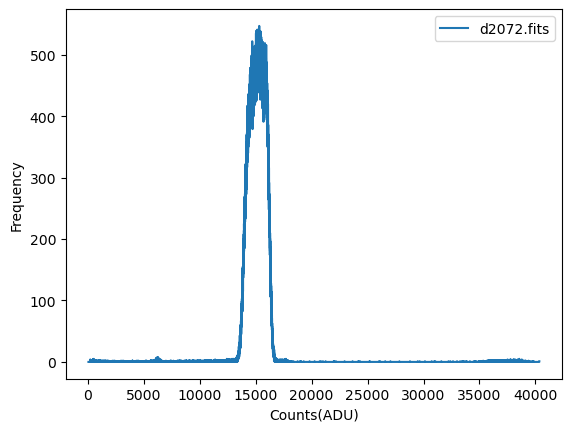

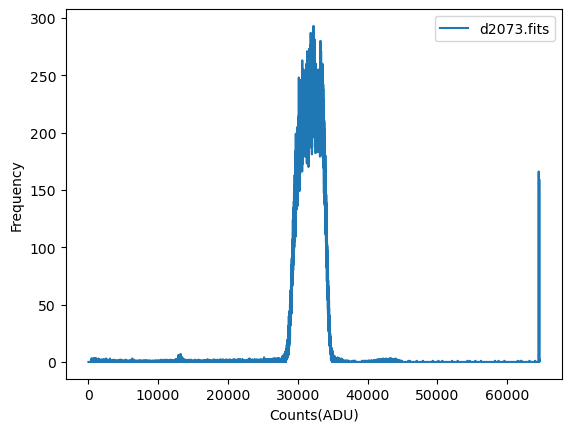

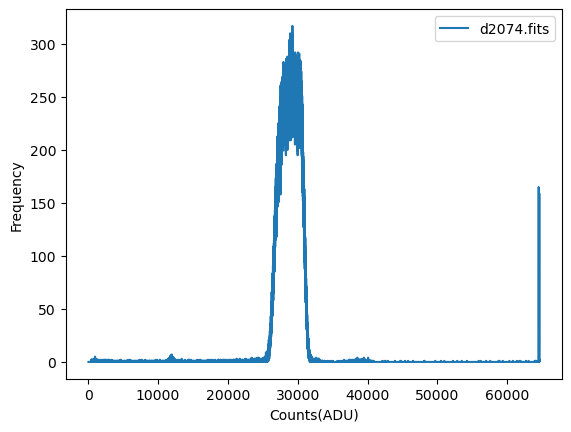

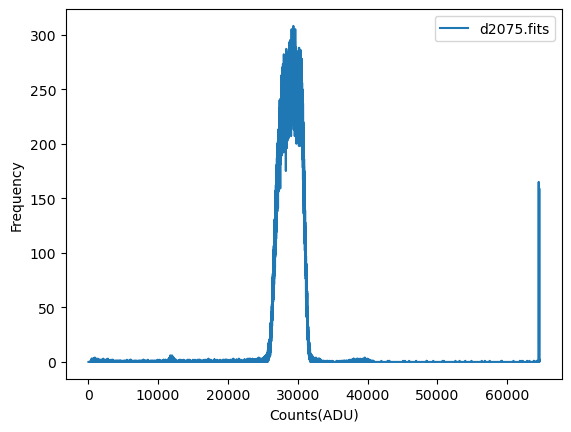

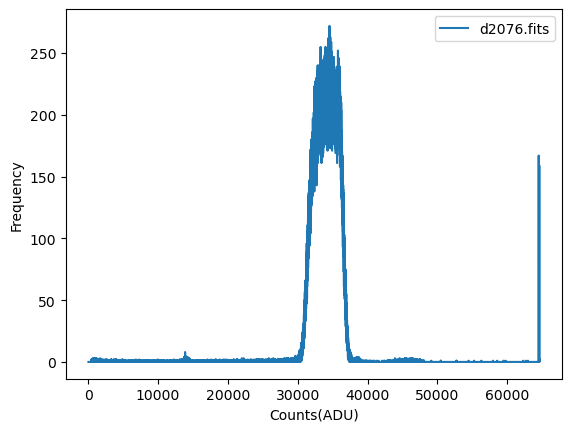

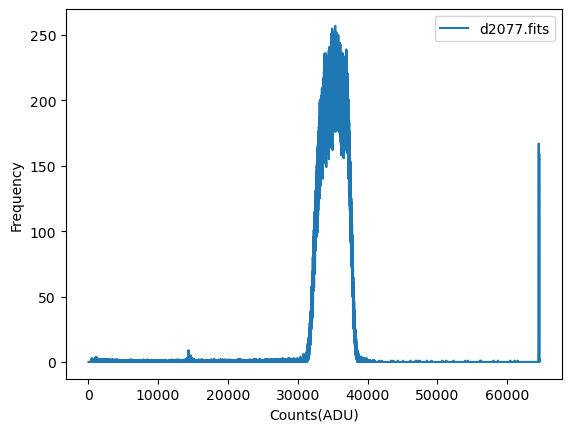

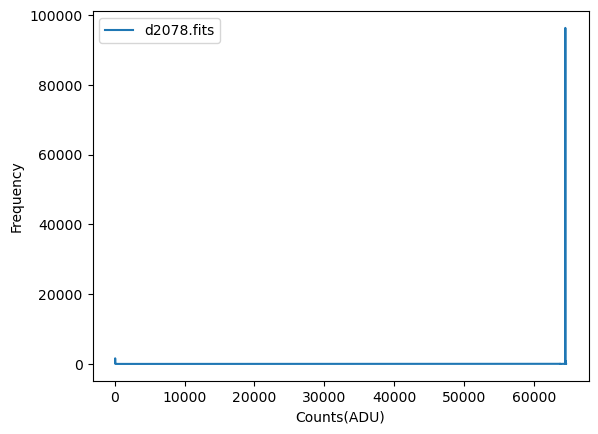

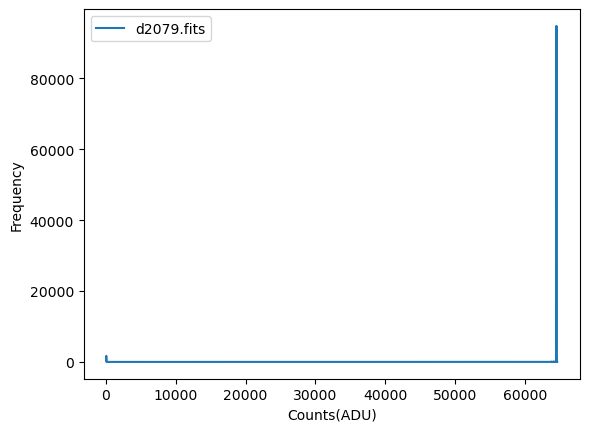

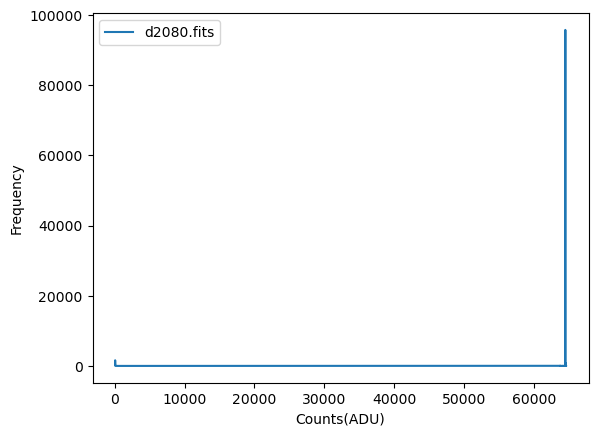

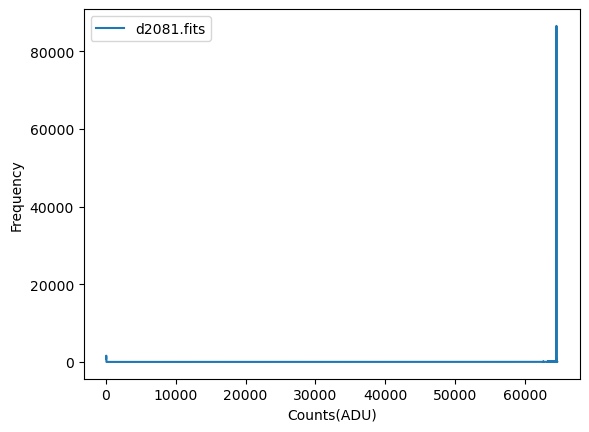

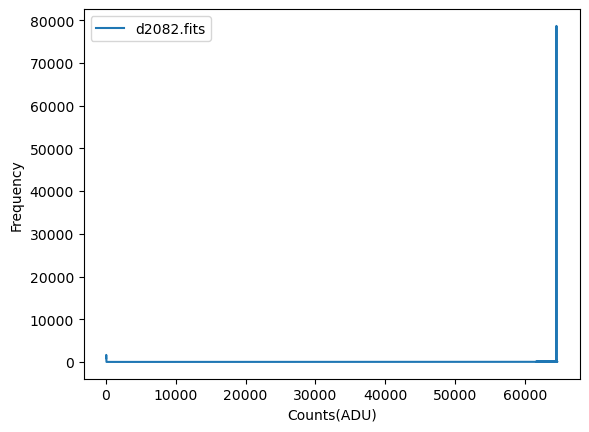

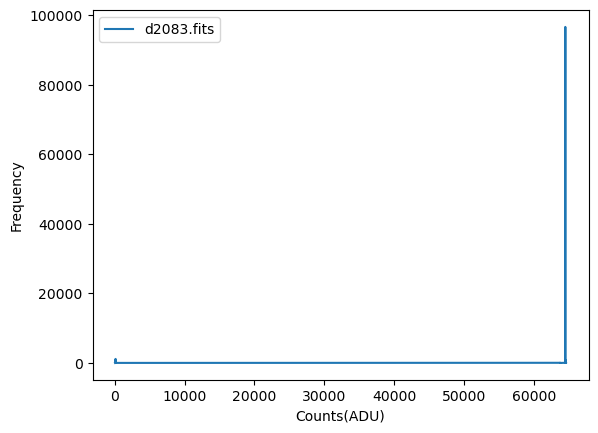

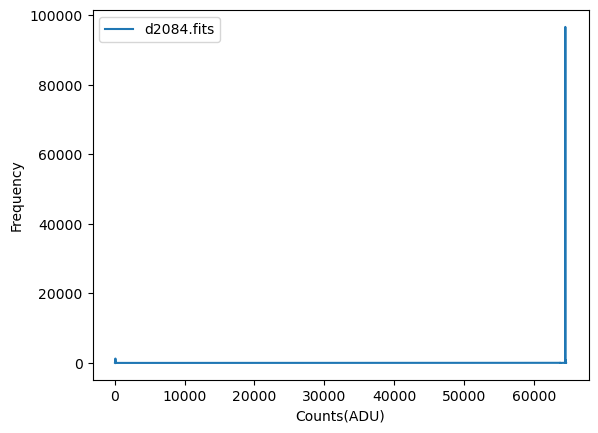

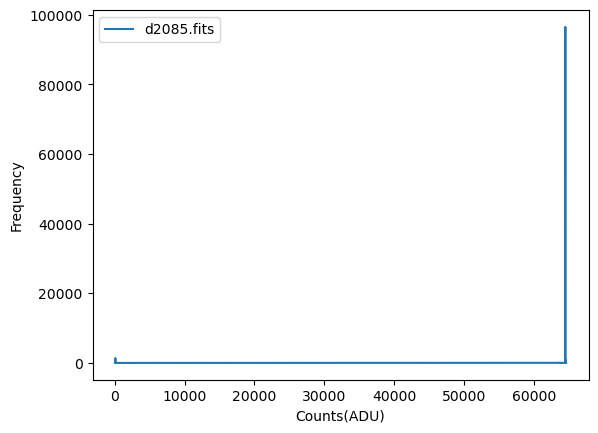

In [217]:
%cd
%cd private/ASTR_150/Lab_1/Images

for i in range(len(data)-11):                           #Plots all non bias fits files
    histogram(removed_bias[i,:], i+43)

Saves each fits file that has had its over scan and median bias removed

In [35]:
#cd into directory with files
%cd
%cd public/data/Lab1

cal_frame = []          #Creates a list that will hold each fits file with the bias and overscan removed
header = []             #Creates a list that will hold the header data of each fits file

c = 0
for file in data_sorted:                                    #Loops through each fits file in sequntial order
    hdu = fits.open(file)                                   #Opens the fits files
    hdr = hdu[0].header                                     #Gets the header of the fits file 
    if hdr['object'] == 'flat':                             #Checks if the fits file is a flat, and will continue if it is (this prevents bias files from continuing)
        img = removed_bias[c,:]                             #Sets img equal to a single row of removed_bias (each row represents a fits fill with the bias removed)
        shaped_img = img.reshape([1024,1056])               #Shapes the img to have the correct dimensions
        for i in range(32):                                 #Iterate through the overscan (there are 32 columns)
            shaped_img = np.delete(shaped_img,1024,1)       #Removes the overscan edge on the right
        cal_frame.append(shaped_img)
        header.append(hdr)
        if c <= 41:                                         #Counts up if a flat file was calibrated (There are 41 of them)
            c += 1

/home/acardaras
/home/acardaras/public/data/Lab1


In [55]:
#cd into directory with files
%cd
%cd private/ASTR_150/Lab_1/Removed_Bias

names = []                                                                 #Creates of list where each element is the name of every calibrated fits file that is ordered

for i, (frame, hdr) in enumerate(zip(cal_frame, header)):                  #Iterates through each  file
    filename = f'calibrated_frame_{i+1}.fits'                              #Determines what to name each calibrated file
    names.append(f'calibrated_frame_{i+1}.fits')                           #Appends to the name list that holds the order of the fits files
    fits.writeto(filename, frame, hdr, overwrite = True)                   #Creates the fits file
    print(f'Saved FITS file: {filename}')

/home/acardaras
/home/acardaras/private/ASTR_150/Lab_1/Removed_Bias
Saved FITS file: calibrated_frame_1.fits
Saved FITS file: calibrated_frame_2.fits
Saved FITS file: calibrated_frame_3.fits
Saved FITS file: calibrated_frame_4.fits
Saved FITS file: calibrated_frame_5.fits
Saved FITS file: calibrated_frame_6.fits
Saved FITS file: calibrated_frame_7.fits
Saved FITS file: calibrated_frame_8.fits
Saved FITS file: calibrated_frame_9.fits
Saved FITS file: calibrated_frame_10.fits
Saved FITS file: calibrated_frame_11.fits
Saved FITS file: calibrated_frame_12.fits
Saved FITS file: calibrated_frame_13.fits
Saved FITS file: calibrated_frame_14.fits
Saved FITS file: calibrated_frame_15.fits
Saved FITS file: calibrated_frame_16.fits
Saved FITS file: calibrated_frame_17.fits
Saved FITS file: calibrated_frame_18.fits
Saved FITS file: calibrated_frame_19.fits
Saved FITS file: calibrated_frame_20.fits
Saved FITS file: calibrated_frame_21.fits
Saved FITS file: calibrated_frame_22.fits
Saved FITS file: 

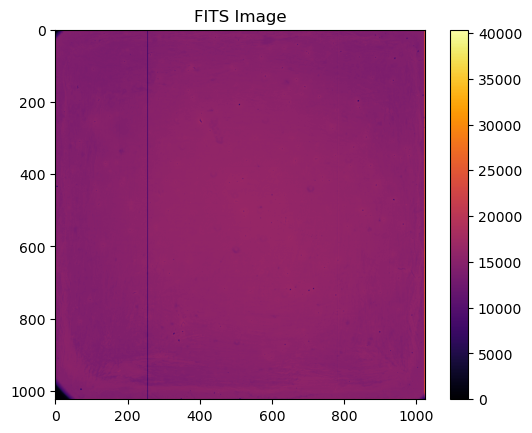

In [37]:
#Uses plt to plot a heatmap of a calibrated frame

hdulist = fits.open('calibrated_frame_30.fits')
image_data = hdulist[0].data
plt.imshow(image_data, cmap='inferno')
plt.colorbar()
plt.title('FITS Image')
plt.show()

Finds the exposure time for each fits file

In [38]:
#cd into directory with files
%cd
%cd private/ASTR_150/Lab_1/Removed_Bias

data_removed = glob.glob('*.fits')                  #Imports data

exposure_time = []
for i in names:                                     #Loops through every file
    hdu = fits.open(i)                              #Opens each fits file
    exposure_time.append(hdu[0].header['EXPTIME']) 

/home/acardaras
/home/acardaras/private/ASTR_150/Lab_1/Removed_Bias


In [47]:
#cd into directory with files
%cd
%cd private/ASTR_150/Lab_1/Removed_Bias


mean = []                                     #Creates an empty list that will hold all mean values
std = []                                      #Creates an empty list that will hold all standard deviation values

for i in names:                               #Loops through each calibrated frame in order
    arr = fits.getdata(i)                     #Imports the data from the fits file
    flat = arr.flatten()                      #Flattens the imported fits file
    mean.append(mean_list(flat))              #Uses the in house mean_list function to find the mean of the calibrated frame
    std.append(std_list(flat))                #Uses the in house std_list function to find the standard deviation of the calibrated frame



variance = np.square(np.array(std))           #Converts std from a list to np.array, then squares each element in the array

x = np.linspace(0,60000,1000)                 #Creates a list of equally spaced values that will be used to plot y = x


/home/acardaras
/home/acardaras/private/ASTR_150/Lab_1/Removed_Bias


/home/acardaras
/home/acardaras/private/ASTR_150/Lab_1/Images


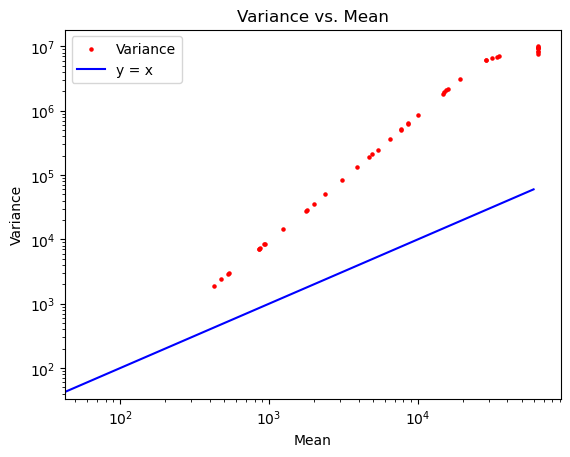

In [48]:
#cd into directory to save plot
%cd
%cd private/ASTR_150/Lab_1/Images

#The code below uses matplotlib.pyplot to make a scatter plot for both Variance vs. Mean

plt.scatter(mean, variance, s = 5, color = 'r', label = 'Variance')
plt.plot(x,x, color = 'b', label = 'y = x')
plt.title('Variance vs. Mean')
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc = 'upper left')
plt.savefig('variance_vs_mean')

In [167]:
#cd into directory with files
%cd
%cd private/ASTR_150/Lab_1/Removed_Bias

mean_apu_seconds = []                                          #Creates a list that will hold the all mean apu/second values

j = 0
for i in names:                                                #Loops through each file in sequential order (ie: 1, 2, 3...)
    arr = fits.getdata(i)                                      #Imports data
    flat = arr.flatten()
    mean_apu_seconds.append(mean_list(flat/exposure_time[j]))  #Uses in house function to find the mean of the flattened fits file/exposure time
    j += 1                                                     #Iterates through the exposure time of the file

/home/acardaras
/home/acardaras/private/ASTR_150/Lab_1/Removed_Bias


In [168]:
#cd into directory with files
%cd
%cd private/ASTR_150/Lab_1/Removed_Bias

std = []                                              #Creates a list that will hold each standard deviation value

j = 0
for i in names:                                       #Loops through each file in sequential order (ie: 1, 2, 3...)
    arr = fits.getdata(i)                             #Imports data
    flat = arr.flatten()
    std.append(std_list(flat/exposure_time[j]))       #Uses in house function to find the standard deviation
    j += 1

/home/acardaras
/home/acardaras/private/ASTR_150/Lab_1/Removed_Bias


/home/acardaras
/home/acardaras/private/ASTR_150/Lab_1/Images


<function matplotlib.pyplot.show(close=None, block=None)>

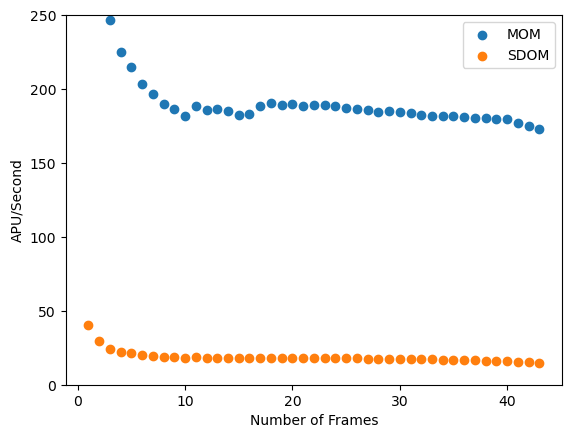

In [154]:
#cd into directory with files
%cd
%cd private/ASTR_150/Lab_1/Images

mom_frames = []         #Creates a list for all the Mean of Means (MOM) values
sdom_frames = []        #Creates a list for all Standard Deviation of the Means (SDOM) values
frame_count = []        #Creates a list that can be used to index the MOM and SDOM values

for i in range(len(mean_apu_seconds)):                                                     #Loops through one more frame every iteration
    mom_frames.append(1/len(mean_apu_seconds[:i+1]) * sum_list(mean_apu_seconds[:i+1]))
    sdom_frames.append((((1/(len(mean_apu_seconds[:i+1])) * sum_list(std[:i+1])))))
    frame_count.append(i+1)

#Plot the number of frames against the MOM and SDOM values
plt.scatter(frame_count,mom_frames, label = 'MOM')
plt.scatter(frame_count,sdom_frames, label = 'SDOM')
plt.ylim(0,250)
plt.xlabel('Number of Frames')
plt.ylabel('APU/Second')
plt.legend(loc = 'upper right')
plt.savefig('MoM_SDOM')
plt.show

/home/acardaras
/home/acardaras/private/ASTR_150/Lab_1/Removed_Bias


/tmp/ipykernel_653/1008838818.py:34: RuntimeWarning: divide by zero encountered in log
  log_factorial = np.log((2*np.pi*x)**.5) + (x) * np.log(x) - x
/tmp/ipykernel_653/1008838818.py:34: RuntimeWarning: invalid value encountered in multiply
  log_factorial = np.log((2*np.pi*x)**.5) + (x) * np.log(x) - x
/tmp/ipykernel_653/1008838818.py:36: RuntimeWarning: divide by zero encountered in log
  log_poisson = x * np.log(u) - log_factorial - u


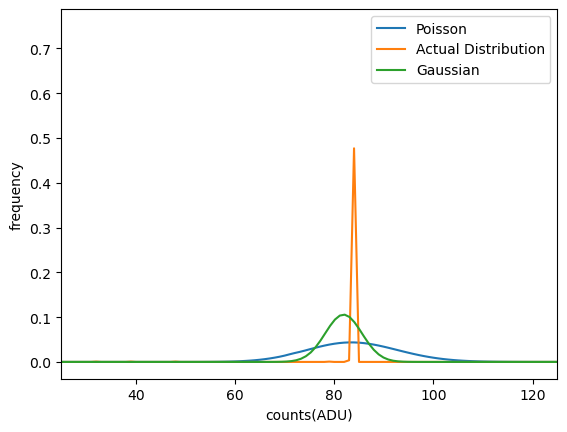

In [219]:
#cd into directory with files
%cd
%cd private/ASTR_150/Lab_1/Removed_Bias

frame_number = 42
frame_name = frame_number + 1
arr = fits.getdata(f'calibrated_frame_%i.fits' %frame_name)   #Imports the data from the fits file
arr = arr/exposure_time[frame_number]
flat = arr.flatten() 

std_poisson = []
mean_poisson = []
gaussian = []


#Calculation the Gassian distribution
for i in range(1024):
    gaussian.append(1/(std[frame_number] * (2*np.pi)**.5) * np.exp(-.5*((i-mean_apu_seconds[frame_number])/std[frame_number])**2))

x_values = np.linspace(0,1000, 1024)

hmin = 0                          
hmax = flat.max()   
values=np.arange(hmin,1024)               #Creates a list of elements from the minimum to max value

freq = []
for i in range(len(values)):              #Counts every time each time a value is repeated
    counts = len(np.where(flat==i)[0])
    freq.append(counts)

for i in range(len(freq)):                #Normalize the actual data distribution
    freq[i] =  exposure_time[frame_number] * freq[i]/len(flat)


#Plot Poisson Distribution
mean = mean_list(arr)
pdf_poisson = poisson(values, mean)
plt.plot(values, pdf_poisson, label = 'Poisson')

#Plot the actual distribution
plt.plot(values, freq, label = 'Actual Distribution')
plt.xlabel('counts(ADU)')
plt.ylabel('frequency')


#Plot the Gaussian Distribution
plt.plot(x_values,gaussian, label = 'Gaussian')
plt.legend()
plt.xlim(25,125)
plt.savefig('poisson_long_exposure')
plt.show()


Measuring Detector Read Noise and Gain

Section 9: Noise and Gain

In [137]:
fits_file = glob.glob('*.fits') # This imports the directory and looks for any file that ends with .fits
fits_file_sorted = sorted(fits_file)

lst_384 = []
lst_12 = []
lst_3 = []
lst_96 = []
lst_768 = []
lst_6 = []
lst_48 = []
lst_192 = []
lst_24 = []
for file in fits_file: # Loops through each fits file

    hdu = fits.open(file) # Opens each fits file
    hdr = hdu[0].header['exptime']# Opens headers
    data = hdu[0].data # Opens data arrays

    if hdr == 384:
        lst_384.append(data)
    elif hdr == 12:
        lst_12.append(data)
    elif hdr == 3:
        lst_3.append(data)
    elif hdr == 96:
        lst_96.append(data)
    elif hdr == 768:
        lst_768.append(data)
    elif hdr == 6:
        lst_6.append(data)
    elif hdr == 48:
        lst_48.append(data)
    elif hdr == 192:
        lst_192.append(data)
    elif hdr == 24:
        lst_24.append(data)

print(len(lst_384))
print(lst_12)
print(lst_3)
print(lst_96)
print(lst_768)
print(lst_6)
print(lst_48)
print(lst_192)
print(lst_24)

5
[array([[  66.,   69.,   84., ...,  754.,  802., 1330.],
       [ 168.,  120.,   89., ..., 1738., 1757., 3542.],
       [ 222.,  127.,  140., ..., 1740., 1857., 3926.],
       ...,
       [  54.,    8.,   14., ...,  755.,  693., 1315.],
       [  29.,   23.,   27., ...,  697.,  592.,  988.],
       [  56.,   15.,   16., ...,  802.,  680.,  978.]], dtype='>f8'), array([[  89.,   64.,   93., ..., 1003., 1053., 1846.],
       [ 204.,  106.,  122., ..., 2256., 2387., 4804.],
       [ 248.,  133.,  146., ..., 2316., 2449., 5344.],
       ...,
       [  66.,   16.,   27., ..., 1052.,  963., 1646.],
       [  63.,   29.,   23., ...,  912.,  771., 1323.],
       [  60.,   27.,   27., ..., 1081.,  874., 1235.]], dtype='>f8'), array([[  62.,   64.,   68., ...,  744.,  755., 1300.],
       [ 200.,  102.,   95., ..., 1746., 1758., 3548.],
       [ 216.,  121.,  114., ..., 1709., 1798., 3950.],
       ...,
       [  50.,   22.,   12., ...,  759.,  695., 1240.],
       [  42.,   14.,   24., ...,  

In [138]:
bias_384 = []
last_index = lst_384[-1]
bias_384.append(last_index)
lst_384.pop()

bias_12 = []
last_index = lst_12[-1]
bias_12.append(last_index)
lst_12.pop()

bias_3 = []
last_index = lst_3[-1]
bias_3.append(last_index)
lst_3.pop()

bias_96 = []
last_index = lst_96[-1]
bias_96.append(last_index)
lst_96.pop()

bias_768 = []
last_index = lst_768[-1]
bias_768.append(last_index)
lst_768.pop()

bias_6 = []
last_index = lst_6[-1]
bias_6.append(last_index)
lst_6.pop()

bias_48 = []
last_index = lst_48[-1]
bias_48.append(last_index)
lst_48.pop()

bias_192 = []
last_index = lst_192[-1]
bias_192.append(last_index)
lst_192.pop()

bias_24 = []
last_index = lst_24[-1]
bias_24.append(last_index)
lst_24.pop()

bias_arr_384 = np.array(bias_384)
bias_arr_12 = np.array(bias_12)
bias_arr_3 = np.array(bias_3)
bias_arr_96 = np.array(bias_96)
bias_arr_768 = np.array(bias_768)
bias_arr_6 = np.array(bias_6)
bias_arr_48 = np.array(bias_48)
bias_arr_192 = np.array(bias_192)
bias_arr_24 = np.array(bias_24)



print(bias_12)
print(bias_24)
print(lst_12)
bias_arr_12.shape

[array([[  79.,   73.,  104., ...,  833.,  882., 1477.],
       [ 180.,   99.,  117., ..., 1871., 1966., 3921.],
       [ 228.,  108.,  135., ..., 1937., 1981., 4537.],
       ...,
       [  58.,   11.,   17., ...,  896.,  808., 1412.],
       [  60.,   35.,   30., ...,  714.,  665., 1096.],
       [  26.,   15.,   10., ...,  604.,  544.,  816.]], dtype='>f8')]
[array([[  175.,   119.,   161., ...,  2270.,  2352.,  4004.],
       [  480.,   277.,   274., ...,  5147.,  5287., 10828.],
       [  543.,   271.,   309., ...,  5214.,  5485., 12028.],
       ...,
       [  121.,    57.,    51., ...,  2302.,  2078.,  3758.],
       [  113.,    58.,    55., ...,  2004.,  1787.,  2886.],
       [  146.,    52.,    39., ...,  2205.,  1828.,  2477.]], dtype='>f8')]
[array([[  66.,   69.,   84., ...,  754.,  802., 1330.],
       [ 168.,  120.,   89., ..., 1738., 1757., 3542.],
       [ 222.,  127.,  140., ..., 1740., 1857., 3926.],
       ...,
       [  54.,    8.,   14., ...,  755.,  693., 1315.],

(1, 1024, 1024)

In [140]:
# print(len(lst_384))
variance = []
means = []
# for frame in lst_384:
#     frame_slice = frame[600:800, 400:600]
#     bias_arr = bias_arr_384.squeeze()
#     bias_slice = bias_arr[600:800, 400:600]
    
#     d_flat = frame_slice.flatten()
#     bias_flats = bias_slice.flatten()
    
#     mean = m(d_flat)
#     means.append(mean)

#     diff = d_flat - bias_flats
#     std = stddev(diff)
#     var = std ** 2
#     variance.append(var)
# print('*********************')
# print(means)
# print('*********************')
# print(variance)

for frame in lst_12:
    frame_slice = frame[600:800, 400:600]
    bias_arr = bias_arr_12.squeeze()
    bias_slice = bias_arr[600:800, 400:600]
    
    d_flat = frame_slice.flatten()
    bias_flats = bias_slice.flatten()
    
    mean = mean_list(d_flat)
    means.append(mean)

    diff = d_flat - bias_flats
    std = std_list(diff)
    var = std ** 2
    variance.append(var)
print('*********************')
print(means)
print('*********************')
print(variance)

for frame in lst_3:
    frame_slice = frame[600:800, 400:600]
    bias_arr = bias_arr_3.squeeze()
    bias_slice = bias_arr[600:800, 400:600]
    
    d_flat = frame_slice.flatten()
    bias_flats = bias_slice.flatten()
    
    mean = mean_list(d_flat)
    means.append(mean)

    diff = d_flat - bias_flats
    std = std_list(diff)
    var = std ** 2
    variance.append(var)
print('*********************')
print(means)
print('*********************')
print(variance)

for frame in lst_96:
    frame_slice = frame[600:800, 400:600]
    bias_arr = bias_arr_96.squeeze()
    bias_slice = bias_arr[600:800, 400:600]
    
    d_flat = frame_slice.flatten()
    bias_flats = bias_slice.flatten()
    
    mean = mean_list(d_flat)
    means.append(mean)

    diff = d_flat - bias_flats
    std = std_list(diff)
    var = std ** 2
    variance.append(var)
print('*********************')
print(means)
print('*********************')
print(variance)

# for frame in lst_768:
#     frame_slice = frame[600:800, 400:600]
#     bias_arr = bias_arr_768.squeeze()
#     bias_slice = bias_arr[600:800, 400:600]
    
#     d_flat = frame_slice.flatten()
#     bias_flats = bias_slice.flatten()
    
#     mean = m(d_flat)
#     means.append(mean)

#     diff = d_flat - bias_flats
#     std = stddev(diff)
#     var = std ** 2
#     variance.append(var)
# print('*********************')
# print(means)
# print('*********************')
# print(variance)

for frame in lst_6:
    frame_slice = frame[600:800, 400:600]
    bias_arr = bias_arr_6.squeeze()
    bias_slice = bias_arr[600:800, 400:600]
    
    d_flat = frame_slice.flatten()
    bias_flats = bias_slice.flatten()
    
    mean = mean_list(d_flat)
    means.append(mean)

    diff = d_flat - bias_flats
    std = std_list(diff)
    var = std ** 2
    variance.append(var)
print('*********************')
print(means)
print('*********************')
print(variance)

for frame in lst_48:
    frame_slice = frame[600:800, 400:600]
    bias_arr = bias_arr_48.squeeze()
    bias_slice = bias_arr[600:800, 400:600]
    
    d_flat = frame_slice.flatten()
    bias_flats = bias_slice.flatten()
    
    mean = mean_list(d_flat)
    means.append(mean)

    diff = d_flat - bias_flats
    std = std_list(diff)
    var = std ** 2
    variance.append(var)
print('*********************')
print(means)
print('*********************')
print(variance)

for frame in lst_24:
    frame_slice = frame[600:800, 400:600]
    bias_arr = bias_arr_24.squeeze()
    bias_slice = bias_arr[600:800, 400:600]
    
    d_flat = frame_slice.flatten()
    bias_flats = bias_slice.flatten()
    
    mean = mean_list(d_flat)
    means.append(mean)

    diff = d_flat - bias_flats
    std = std_list(diff)
    var = std ** 2
    variance.append(var)
print('*********************')
print(means)
print('*********************')
print(variance)

for frame in lst_192:
    frame_slice = frame[600:800, 400:600]
    bias_arr = bias_arr_192.squeeze()
    bias_slice = bias_arr[600:800, 400:600]
    
    d_flat = frame_slice.flatten()
    bias_flats = bias_slice.flatten()
    
    mean = mean_list(d_flat)
    means.append(mean)

    diff = d_flat - bias_flats
    std = std_list(diff)
    var = std ** 2
    variance.append(var)
print('*********************')
print(means)
print('*********************')
print(variance)

*********************
[1877.0538, 2517.965925, 1855.4253, 3251.53505]
*********************
[2304.2159373775166, 2658.7624132243163, 2279.1069976775157, 3315.3172164400025]
*********************
[1877.0538, 2517.965925, 1855.4253, 3251.53505, 504.8303, 556.327625, 1321.6171, 448.084375]
*********************
[2304.2159373775166, 2658.7624132243163, 2279.1069976775157, 3315.3172164400025, 659.2616606974922, 692.7394529843803, 1214.3602269775117, 636.9494336093888]
*********************
[1877.0538, 2517.965925, 1855.4253, 3251.53505, 504.8303, 556.327625, 1321.6171, 448.084375, 16313.6366, 16775.5988, 15872.939425, 15407.1318]
*********************
[2304.2159373775166, 2658.7624132243163, 2279.1069976775157, 3315.3172164400025, 659.2616606974922, 692.7394529843803, 1214.3602269775117, 636.9494336093888, 23459.86766815993, 23803.59752500067, 24333.20983085904, 24585.67010600041]
*********************
[1877.0538, 2517.965925, 1855.4253, 3251.53505, 504.8303, 556.327625, 1321.6171, 448.0843

In [142]:
means = np.array(means)
variance = np.array(variance) / 2

s, c = np.polyfit(means, variance, 1)

var_fit = s * means + c

sorted_idx = np.argsort(means)
means_sorted = means[sorted_idx]
var_fit_sorted = var_fit[sorted_idx]
print(s)

0.609576770595478


In [150]:
print(c)

149.9398018081084


Noise = sqrt(y-int) = sqrt(c)

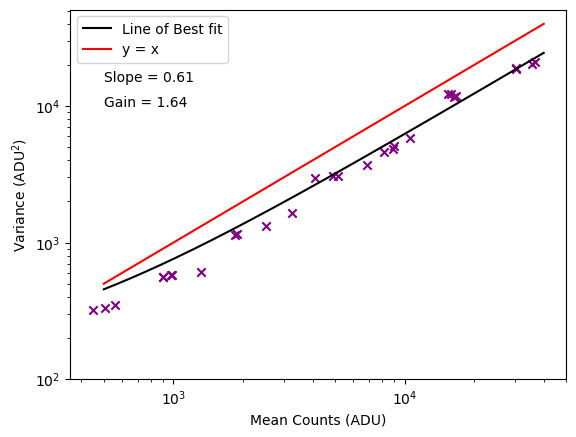

In [210]:
x = np.linspace(500, 40000, 40000)

plt.scatter(means, variance, marker = 'x', color = 'purple')
plt.plot(x, (x*s) + c, label = 'Line of Best fit', color = 'black')
plt.plot(x, x, color = 'red',label = 'y = x')
plt.xlabel('Mean Counts (ADU)')
plt.ylabel(r'Variance ($\mathrm{ADU^2}$)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**2)
plt.legend()
plt.text(500, 10000, r'Gain = 1.64')
plt.text(500, 15000, r'Slope = 0.61')
plt.savefig('variance_vs_adu')
plt.show()